This notebook explores the overhead and gate depth for implementing the coupling term of the simplest spin-boson Hamiltonian on two hardware platforms: hybrid oscillator-qubit hardware and pure qubit hardware. The spin-boson Hamiltonian is given by:

$$
\hat{H}_{SB} = \frac{1}{2} \sum_i g_i \omega_i \left( b_i + b_i^\dagger \right),
$$

where $ \omega = 2 $, $ g $ is the coupling constant, and we consider a single spin coupled a bath of ($ n_{\text{max}} = 3 $), i.e.

$$
H = g \sum_i \left( b^\dagger + b \right).
$$

In [18]:
import sys
import os

# Adjust the path based on your directory structure
module_path = os.path.abspath(os.path.join('..', '..'))  # Moves two directories up
if module_path not in sys.path:
    sys.path.append(module_path)
    
# Now you can import c2qa and other modules from bosonic-qiskit
import c2qa
import qiskit
import numpy as np
import c2qa.util as util
import matplotlib.pyplot as plt
import matplotlib

### Boson-qubit mapping
For $ n_{\text{max}} = 3 $, using the Fock-binary encoding, the coupling term is:

$$
H = \frac{g}{2} \left[
(1 + \sqrt{3})XIX
+ (1 - \sqrt{3})XZX
+ \sqrt{2}XXX
+ \sqrt{2}XYY
\right].
$$

We can use qiskit to Trotterize $e^{-iHt}$, and find the gate count for a single Trotter step.


In [19]:
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import Statevector
from math import sqrt
import matplotlib.pyplot as plt

# Choose arbitrary g for now
g = 1.0  

# Define the Hamiltonian terms
# Each tuple consists of (Pauli string, coefficient)
terms = [
    ("XIX", (1 + sqrt(3)) / 2 * g),
    ("XZX", (1 - sqrt(3)) / 2 * g),
    ("XXX", sqrt(2) / 2 * g),
    ("XYY", sqrt(2) / 2 * g)
]

# terms = [("III", (1))] #Test with identity

# Create the SparsePauliOp for the Hamiltonian
hamiltonian = SparsePauliOp.from_list(terms, num_qubits=3).simplify()

print("Hamiltonian:")
print(hamiltonian)

# Define the initial state (e.g., |100⟩)
initial_state = Statevector.from_label("100")
print("\nInitial State:")
print(initial_state)


Hamiltonian:
SparsePauliOp(['XIX', 'XZX', 'XXX', 'XYY'],
              coeffs=[ 1.3660254 +0.j, -0.3660254 +0.j,  0.70710678+0.j,  0.70710678+0.j])

Initial State:
Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j],
            dims=(2, 2, 2))


In [20]:
from qiskit_algorithms import TimeEvolutionProblem
from qiskit_algorithms import TrotterQRTE

# Define the time evolution problem
final_time = 1.0  # Total time for evolution corresponds to one Trotter step
problem = TimeEvolutionProblem(hamiltonian, initial_state=initial_state, time=final_time)

trotter = TrotterQRTE()

# Perform the evolution
result = trotter.evolve(problem)

result.evolved_state.draw()


┌──────────────┐┌──────────────────────────────────────┐
q_0: ┤0             ├┤0                                     ├
     │              ││                                      │
q_1: ┤1 circuit-242 ├┤1 exp(-it (XIX + XZX + XXX + XYY))(1) ├
     │              ││                                      │
q_2: ┤2             ├┤2                                     ├
     └──────────────┘└──────────────────────────────────────┘

OrderedDict([('h', 16), ('cx', 12), ('rz', 3), ('sdg', 2), ('s', 2), ('state_preparation', 1), ('rxx', 1)])


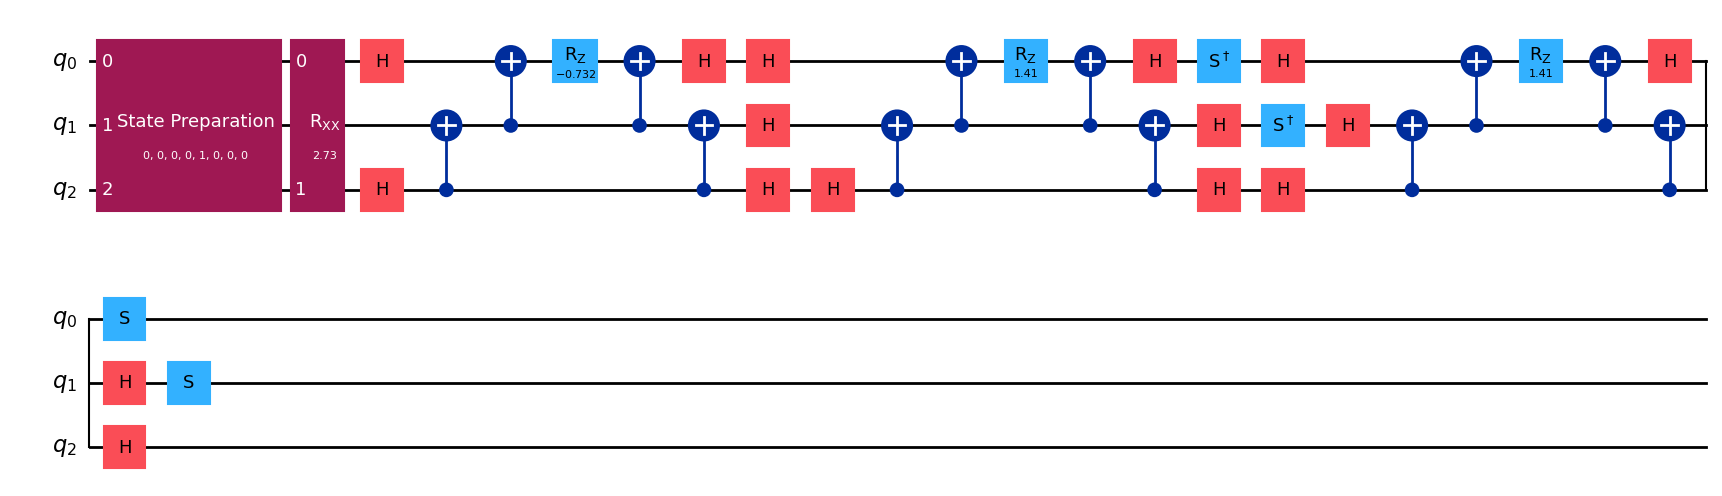

In [23]:
decomposed_circ = result.evolved_state.decompose(reps=1).decompose("disentangler_dg").decompose(
    "multiplex1_reverse_dg"
)

print(decomposed_circ.count_ops())
decomposed_circ.draw('mpl')